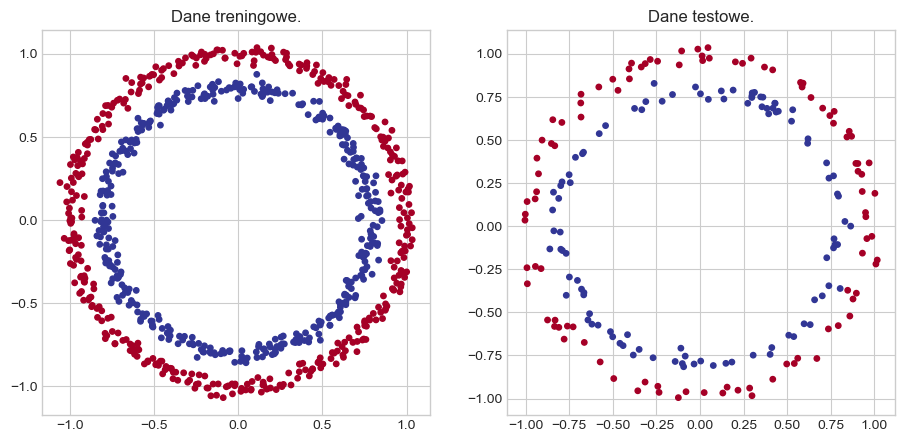

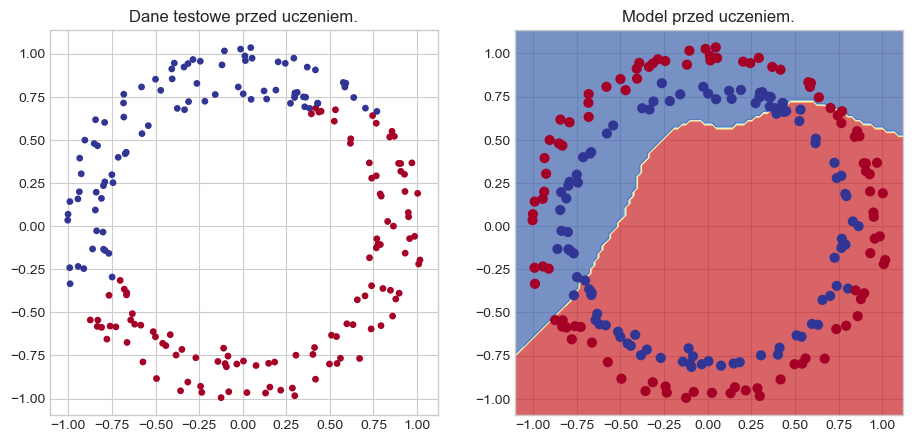

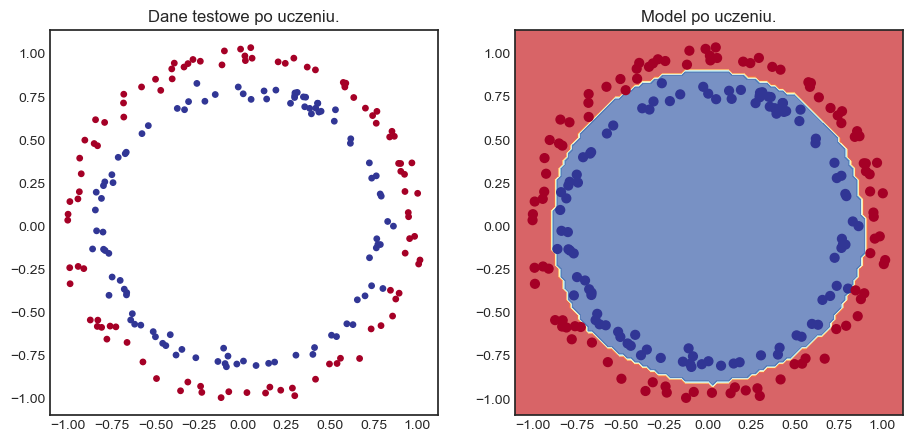

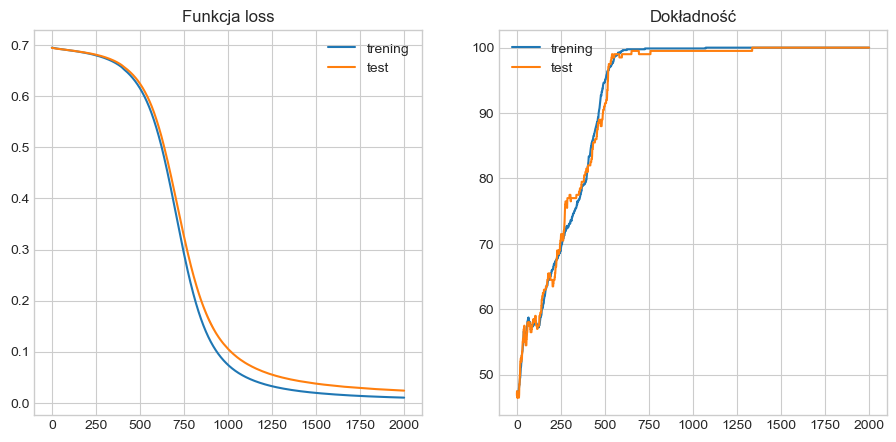

In [4]:
# CELE
# Maszyna ma na celu rozdzielenie danych poukładanych w dwa okręgi z punktów.
# Dane do uczenia to dwie tablice X[x,y] -> pozycja na płaszczyźnie, y[0,1] -> 0 to okrąg zewnętrzny, 1 to okrąg wewnętrzny.
# Dane są wymieszane, ale wg indexu każdy x,y ma odpowiednie odniesieni w postaci 0 lub 1.

# ---------------------------------------------------------------------------------------------
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn, set_seeds, plot_loss_curves

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

# ---------------------------------------------------------------------------------------------
# generowanie danych, dwa koła z punktów jedno w drugim X[(x,y)pozycja], y[0 lub 1], dane wymieszane
from sklearn.datasets import make_circles 
X, y = make_circles(1000, noise=0.03, random_state=42)

# ---------------------------------------------------------------------------------------------
# zamiana na tensory i ustalwienie na cuda, oraz rozłożenie na trening i test
X = torch.tensor(X).type(torch.float32).to(device)
y = torch.tensor(y).type(torch.float32).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------------------------------------------------------------------------
# wizualizacja danych treningowych i testowych

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title('Dane treningowe.')
plt.scatter(X_train[:,0].cpu().numpy(), X_train[:,1].cpu().numpy(), s=15, c=y_train.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title('Dane testowe.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=15, c=y_test.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.show()

# ---------------------------------------------------------------------------------------------
# klasa modelu
class ModelNN(nn.Module):
    def __init__(self):
        super().__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.layer_1 = nn.Linear(in_features=2, out_features=32) 
        self.layer_2 = nn.Linear(in_features=32, out_features=32) 
        self.layer_3 = nn.Linear(in_features=32, out_features=1) 
        self.relu = nn.ReLU() # dodanie funkcji aktywacyjnej nie liniowej, łamie linie na mniejsze
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
# instancja modelu
set_seeds(42)
model = ModelNN().to(device)

# ---------------------------------------------------------------------------------------------
# przewidywania przed uczeniem
with torch.inference_mode(): 
    y_pred = model(X_test)
    y_logits = model(X_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title('Dane testowe przed uczeniem.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=15, c=y_pred.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title('Model przed uczeniem.')
plot_decision_boundary(model, X_test, y_test)

# ---------------------------------------------------------------------------------------------
# Ustawienia loss i optymalizator
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1) 

# ---------------------------------------------------------------------------------------------
epochs = 2000
epoch_count = []
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# pętla treningowa i danych testowych
for epoch in range(epochs):
    epoch_count.append(epoch)

    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss wymaga jako wejście raw preds, i przeliczonych po sigmoid 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss_values.append(loss.cpu().detach().numpy())
    train_acc_values.append(acc)    

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_test).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        loss = loss_fn(y_logits, y_test)
        acc = accuracy_fn(y_true=y_test, y_pred=y_pred)
        test_loss_values.append(loss.cpu().detach().numpy())
        test_acc_values.append(acc)  

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title('Dane testowe po uczeniu.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=15, c=y_pred.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title('Model po uczeniu.')
plot_decision_boundary(model, X_test, y_test)

plot_loss_curves({"train_loss": train_loss_values, "train_acc": train_acc_values, "test_loss": test_loss_values, "test_acc": test_acc_values})